# Catching Issues in a Product Catalog (Multimodal Dataset)

<head>
  <meta name="title" content="Catching Issues in a Product Catalog (Multimodal Dataset)"/>
  <meta property="og:title" content="Catching Issues in a Product Catalog (Multimodal Dataset)"/>
  <meta name="twitter:title" content="Catching Issues in a Product Catalog (Multimodal Dataset)" />
  <meta name="image" content="/img/multimodal-issues.png" />
  <meta property="og:image" content="/img/multimodal-issues.png" />
  <meta name="description" content="A quick tutorial using an automated Data-Centric AI platform."  />
  <meta property="og:description" content="A quick tutorial using an automated Data-Centric AI platform." />
  <meta name="twitter:description" content="A quick tutorial using an automated Data-Centric AI platform." />
</head>

This tutorial demonstrates how e-commerce businesses can use Cleanlab Studio to ensure high-quality product catalogs. 
Follow this tutorial to see how to programatically audit a multimodal dataset (with images, text, and structured/tabular numeric/categorical features) using the Cleanlab Studio [Python API](/studio/quickstart/api/).

<div style={{display: 'block', margin: 'auto'}}>
    <iframe width="560" height="315" src="https://www.youtube.com/embed/Yf1H4Uoqylg?si=G3lgOc_WBlFGJUYG"></iframe>
</div>

Cleanlab Studio handles such multimodal data (eg. product images, titles/descriptions, and price, size, brand, ...) to auto-detect many common issues in product catalogs, including:

- Products (SKUs) that are miscategorized or have incorrect tags (tax-classifications, age-restrictions, ...)
- Near-duplicate products (SKUs)
- Products with images that are low-quality (over/under-exposed, blurry, low information, ...) or NSFW
- Products with text titles/descriptions/reviews that are low-quality (non-English/unreadable) or unsafe (toxic language, PII)
- Products whose image does not match description
- Products whose price, size, or other numeric attribute seems off. 

![Issues detected in a product catalog](./assets/multimodal-dataset-tutorial/multimodal-issues.png)

## Install and import dependencies

Make sure you have `wget` and `zip` installed to run this tutorial. You can use `pip` to install all other packages required for this tutorial as follows:

In [ ]:
%pip install -U Pillow cleanlab-studio

In [1]:
import numpy as np
import pandas as pd
import os
import random

from IPython.display import display, Markdown

pd.set_option("display.max_colwidth", None)

## Get the dataset

This tutorial uses a variant of this [retailer's product catalog dataset](https://www.kaggle.com/datasets/PromptCloudHQ/all-jc-penny-products) with the following information about each product/SKU: 

- product category (11 unique classes)
- sale price, average rating (numeric features in structured/tabular format)
- brand (categorical feature in structured/tabular format)
- title, description (text fields)
- image of the product

The data are in a CSV file, with images stored in a seperate directory (their filepaths are listed in a column of the CSV). 
Let's download the dataset:

In [ ]:
!wget -nc https://cleanlab-public.s3.amazonaws.com/Datasets/product_catalog.zip -O product_catalog.zip
!unzip -q product_catalog.zip

The unzipped data directory `product_catalog/` has the following structure:

```bash
product_catalog/                 # Main directory after unzipping the archive.
|
|-- metadata.csv                 # CSV of product information (tabular and text fields, filepaths to images)
|         
|-- images/                      # Directory containing product images
|   |-- <image_filename_1>.jpg   # Example of an image file 
|   |-- <image_filename_2>.jpg   # Another image file
|   |-- ...
```

Each row (data point) in the CSV file corresponds to a product within the catalog. Let's load the data:

In [3]:
BASE_PATH = os.getcwd()
dataset_path = os.path.join(BASE_PATH, "product_catalog")

data = pd.read_csv(os.path.join(dataset_path, "metadata.csv"))
data.head(1)

,sku,title,description,brand,sale_price,average_product_rating,image,category
0,53d474313dd0,Park B. Smith® Chevron Foil-Printed Decorative Pillow,"A chic foil-printed chevron pattern and luxurious comfort make this elegant decorative pillow a must-have accent piece for your formal living space. foil-printed cover plush and soft cotton cover with feather fill spot clean 12x18"" imported",Park B Smith,43.5,3.0,images/0.jpg,bed & bath


**Optional: Initialize helper methods to view images in the DataFrame**



In [4]:
import pathlib
from PIL import Image
from io import BytesIO
from base64 import b64encode
from IPython.display import HTML

BASE_PATH = os.getcwd()


def path_to_img_html(path: str) -> str:
    buf = BytesIO()
    Image.open(path).convert("RGB").save(buf, format="JPEG")
    b64 = b64encode(buf.getvalue()).decode("utf8")
    return f'<img src="data:image/jpeg;base64,{b64}" width="175" alt="" />'


def display_image(df):
    image_column = "rendered_image"
    df_copy = df.copy()
    df_copy[image_column] = df_copy["image"].apply(
        lambda x: pathlib.Path(BASE_PATH).joinpath("product_catalog").joinpath(x)
    )

    # Rearrange columns to move image_column after "image"
    columns = list(df_copy.columns)
    columns.remove(image_column)
    columns.insert(1, image_column)
    df_copy = df_copy[columns]
    return HTML(
        df_copy.to_html(escape=False, formatters={image_column: path_to_img_html})
    )

,sku,rendered_image,title,description,brand,sale_price,average_product_rating,image,category
0,53d474313dd0,,Park B. Smith® Chevron Foil-Printed Decorative Pillow,"A chic foil-printed chevron pattern and luxurious comfort make this elegant decorative pillow a must-have accent piece for your formal living space. foil-printed cover plush and soft cotton cover with feather fill spot clean 12x18"" imported",Park B Smith,43.50,3.0,images/0.jpg,bed & bath
1,4a1e2abd23c0,,a.n.a Jeggings - Plus size,"Our a.n.a® jeggings gives you the look of super skinny jeans that you love to pair with your favorite tops. flat front back pockets 31"" inseam cotton/Lyocell/polyester/spandex washable imported",A.N.A,36.25,4.8,images/1.jpg,pants
2,debf3b021522,,Carter's® Bunny Slippers - Baby Girls,Little feet will look cuter than ever—and stay warm and cozy—in these precious bunny slippers from Carter's. 3D ears embroidered face 3D tail faux fur lining synthetic wipe clean with damp cloth imported,Carter's,10.14,4.5,images/2.jpg,shoes

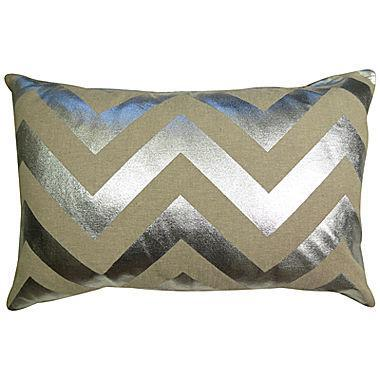
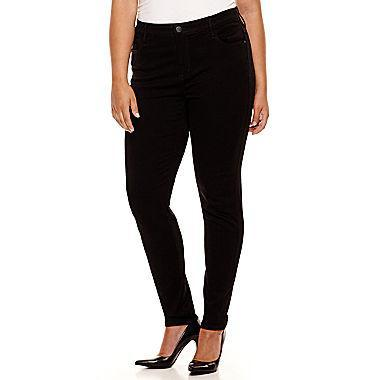
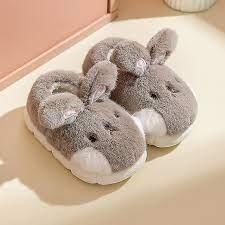

In [5]:
display_image(data.head(3))

## Load data into Cleanlab Studio

The multimodal product catalog dataset is spread in 2 formats: tabular and image. We'll load both into Cleanlab Studio.

First use your API key to instantiate a `Studio` object.

In [6]:
from cleanlab_studio import Studio

# You can find your Cleanlab Studio API key by going to studio.cleanlab.ai/upload,
# clicking "Upload via Python API", and copying the API key there
API_KEY = "<insert API key here>"

# Initialize studio object
studio = Studio(API_KEY)

For loading the image data, we use the Metadata ZIP format and for loading the text/tabular data, we use the CSV format. Both formats are detailed in the [dataset guide](/studio/concepts/datasets/).

### Load image data

The Metadata ZIP format requires a CSV file named `metadata.csv` with at least these 2 columns:
- image's path - contains the relative file-path for each image. Filepaths should **not** include the parent folder (product_catalog/ in this example)
- label - contains the label for each image.

The dataset used in this tutorial adheres to this format. Our "metadata.csv" file contains both "image" and "category" columns, with other columns being optional and not used for training AI models in the image modality
<br /> The ZIP file we downloaded can be directly loaded into Cleanlab Studio.

**Note**: To work with big image datasets, we recommend hosting them in cloud storage (rather than a local ZIP file), as demonstrated in this tutorial: [Finding Issues in Large-Scale Image Datasets](/studio/tutorials/cleanlab-studio-api/large_image_datasets).

In [ ]:
image_dataset_id = studio.upload_dataset(
    "product_catalog.zip", dataset_name="multimodal-image"
)
print(f"Dataset ID: {image_dataset_id}")

### Load tabular data

The tabular data contains categorical, numeric, and text features. Before loading the DataFrame, let's remove the "image" column since its redundant for tabular and text modality. When loading the dataset into Cleanlab Studio, we explicitly set the type for the `sale_price` column to `float` since we'll be running a [regression project](https://help.cleanlab.ai/studio/concepts/datasets/#regression) with `sale_price` as the label column later in this tutorial (the label column must have `float` type for a regression project, otherwise this step is optional). See [this guide](https://help.cleanlab.ai/studio/concepts/datasets/#schema-updates) for more information on schema overrides.

In [ ]:
# Remove "image" column
data_copy = data.copy()
data_copy.drop(columns="image", inplace=True)

tabular_dataset_id = studio.upload_dataset(
    data_copy,
    dataset_name="multimodal-tabular",
    schema_overrides=[{"name": "sale_price", "column_type": "float"}],
)
print(f"Dataset ID: {tabular_dataset_id}")

## Launch projects

A Cleanlab Studio project automatically trains ML models to provide AI-based analysis of your dataset. 

Here we launch multiple projects, each analyzing a particular aspect of the product information. In total, we run the following 3 projects:

1. Image project:        with the product images
2. Text project:           with the product descriptions
3. Tabular project:      with all the numeric/string product features

In each project, we treat the product category as a label. Since each product belongs to exactly one category, this is a multi-class classifcation task. 
If you are instead analyzing product tags (where one or more tags can apply to the same product), specify that your task is multi-label classification instead.

The image project is based on the previously uploaded image dataset (`image_dataset_id`).


In [ ]:
# Name of the column containing labels
label_column = "category"

image_project_id = studio.create_project(
    dataset_id=image_dataset_id,
    project_name="multimodal-image",
    modality="image",
    task_type="multi-class",
    model_type="regular",
    label_column=label_column,
)
print(
    f"Project successfully created and training has begun! project_id: {image_project_id}"
)

For the rest of the projects, we use previously uploaded tabular dataset (`tabular_dataset_id`).

For each project, we specify certain input text or tabular column(s) to use as predictive features. In each project, Cleanlab will train a separate AI model to predict the label based on these features.

In [ ]:
# Name of the column containing product description
product_description_column = "description"

description_project_id = studio.create_project(
    dataset_id=tabular_dataset_id,
    project_name="multimodal-text-description",
    modality="text",
    task_type="multi-class",
    model_type="regular",
    label_column=label_column,
    text_column=product_description_column,
)
print(
    f"Project successfully created and training has begun! project_id: {description_project_id}"
)

In [ ]:
# Name of the columns for tabular data modelling
tabular_columns = [
    "title",
    "description",
    "sale_price",
    "average_product_rating",
    "brand",
]

tabular_project_id = studio.create_project(
    dataset_id=tabular_dataset_id,
    project_name="multimodal-tabular",
    modality="tabular",
    task_type="multi-class",
    model_type="regular",
    label_column=label_column,
    feature_columns=tabular_columns,
)
print(
    f"Project successfully created and training has begun! project_id: {tabular_project_id}"
)

Once the projects have been launched successfully and the `project_id`'s are visible, feel free to close this notebook. It will take time for Cleanlab’s AI to train these models and analyze your data. Come back after training is complete (you will receive an email) and continue with the notebook to review your results. For this tutorial, every project will produce a *cleanset* (cleaned dataset) within around 20 minutes.

**You should only execute the above cells once!** Do not call `create_project` again.

Before we proceed with the rest of the tutorial, we will wait for all the projects to complete. 

You can poll for project's status to programmatically wait until the results (and *cleanset*) are ready for review:

In [ ]:
# Fetch cleanset_id
image_cleanset_id = studio.get_latest_cleanset_id(image_project_id)
# Poll for project status
project_status = studio.wait_until_cleanset_ready(image_cleanset_id)

description_cleanset_id = studio.get_latest_cleanset_id(description_project_id)
project_status = studio.wait_until_cleanset_ready(description_cleanset_id)

tabular_cleanset_id = studio.get_latest_cleanset_id(tabular_project_id)
project_status = studio.wait_until_cleanset_ready(tabular_cleanset_id)

## Get project results

We can fetch the [Cleanlab columns](/studio/concepts/cleanlab_columns/) that contain the metadata for the [cleanset](/studio/concepts/cleanset) using its `cleanset_id`. These columns have the same length as our original data and provide metadata about each individual data point, like what types of issues it exhibits and how severely.

If at any point you want to re-run the remaining parts of this notebook (without creating another Project), simply call `studio.download_cleanlab_columns(cleanset_id)` with the `cleanset_id` printed from the previous cells.

In [13]:
# Download cleanlab columns from image project
image_cleanlab_columns = studio.download_cleanlab_columns(image_cleanset_id)
# Download cleanlab columns from description text project
description_cleanlab_columns = studio.download_cleanlab_columns(description_cleanset_id)
# Download cleanlab columns from tabular project
tabular_cleanlab_columns = studio.download_cleanlab_columns(tabular_cleanset_id)

### Label issues detected in tabular project

Each Cleanlab project auto-detects many different types of issues in the corresponding dataset. We demonstrate how to programmatically review these issues, and which data points exhibit them. Let's start with *label issues*.  First, we merge the Cleanlab columns with the original DataFrame to view them jointly.

In [15]:
# Combine original DataFrame with Cleanlab columns
tabular_cleanlab_df = data.merge(
    tabular_cleanlab_columns, left_index=True, right_index=True
)

# Set "given_label" column to the original label
tabular_cleanlab_df.rename(columns={"category": "given_label"}, inplace=True)

Recall that we specified the product category as the *label* in the project. To see which data points Cleanlab has estimated to be mislabeled, we filter by `is_label_issue`. For our tutorial dataset, these *label issues* correspond to products that are likely miscategorized. We sort the label issues by `label_issue_score` to see which of these data points are *most likely* mislabeled.

In [16]:
tabular_label_issue = tabular_cleanlab_df.query(
    "is_label_issue", engine="python"
).sort_values("label_issue_score", ascending=False)

# Select columns to display results
label_issue_columns = [
    "given_label",
    "suggested_label",
    "label_issue_score",
    "is_label_issue",
]
columns_to_display = tabular_columns + label_issue_columns

display(tabular_label_issue.head()[columns_to_display])

,title,description,sale_price,average_product_rating,brand,given_label,suggested_label,label_issue_score,is_label_issue
718,Nike® 3-pk. Dri-FIT Low Cut Socks,The Nike Dri-FIT® low-cut socks give you the moisture-wicking performance and cushioned support you need. dri-FIT® moisture technology wicking keeps feet cool and dry maximum breathability cushioned footbed for comfort arch compression for perfected fit polyester/nylon/cotton/spandex washable imported sock size 10-13 fits shoe sizes 8-12,21.14,3.1,Nike,accessories,underwear & socks,0.994825,True
357,Liz Claiborne® Emma Cropped Ankle Pants - Plus,"Our cropped ankle pants have a straight leg and sleek look that you'll love wearing to work or on nights out. ● hook-and-bar with zip closure● straight leg● back pockets● 23"" inseam● cotton/rayon/spandex● washable● imported",31.42,4.9,LIZ CLAIBORNE,shorts,pants,0.985283,True
736,Speedo® Tropical Striped Swim Trunks,"The VaporPLUS quick-drying fabric of our swim trunks will keep you comfortable no matter how many times you go in the water. UPF 50+ protection relaxed fit mesh liner Veclro® fly with string closure inside key pocket side seam pockets 10"" inseam polyester machine wash, hang dry imported",39.87,5.0,Speedo,shorts,swimwear,0.977736,True
509,Speedo® Straight Away Swim Trunks,"Featuring the latest quick-drying technology, our Speedo swim trunks will be your go-to for your days by the beach or pool. Block the Burn® UPF 50+ protection VaporPLUS™ quick-drying fabric relaxed fit Velcro® fly with drawstring side seam pockets interior key pocket mesh liner 10"" inseam polyester machine wash, hang dry imported",39.87,5.0,Speedo,shorts,swimwear,0.967584,True
341,Stylus™ Long-Sleeve Textured Cable Sweater,"Our classic crewneck cable-knit sweater gets a casual update with a flatteringly comfortable fit. cotton/acrylic side slits high-low hem machine wash, dry flat imported misses: approx. 24½"" - 29½"" length petite: approx. 23"" - 25"" length",15.70,4.4,STYLUS,tops,coats & jackets,0.956729,True


The above analysis implies that the category assigned to these products is wrong. Such errors can hamper discoverability, worsen customer experience, and degrade ML/Analytics efforts.

### Label issues and outliers detected in "description" text project

We'll repeat the steps of merging Cleanlab columns with the original DataFrame and filter the merged DataFrame for data points flagged with label issues.

In [15]:
# Combine description DataFrame with Cleanlab columns
description_cleanlab_df = data.merge(
    description_cleanlab_columns, left_index=True, right_index=True
)
description_cleanlab_df.rename(columns={"category": "given_label"}, inplace=True)

# Filter label issues
description_label_issue = description_cleanlab_df.query(
    "is_label_issue", engine="python"
).sort_values("label_issue_score", ascending=False)
columns_to_display = [product_description_column] + label_issue_columns

display(description_label_issue.head()[columns_to_display])

,description,given_label,suggested_label,label_issue_score,is_label_issue
738,"Crochet edges give our sweater tank top a look of class that's also ready for the weekend. v-neck approx. 24"" - 27½"" length cotton/polyester/Lurex® metallic washable imported",coats & jackets,tops,0.755175,True
983,Gotham City will be cleaned up in no time when you've got our Batman flip flops. nubuck/synthetic/nylon upper spot clean synthetic sole,swimwear,shoes,0.733110,True
357,"Our cropped ankle pants have a straight leg and sleek look that you'll love wearing to work or on nights out. ● hook-and-bar with zip closure● straight leg● back pockets● 23"" inseam● cotton/rayon/spandex● washable● imported",shorts,pants,0.720278,True
728,"With just the right touch of trendy ombre coloring, our Alfred Dunner layered sweater brings some modern excitement to your wardrobe and then it tops it off with a pretty necklace for a pulled together look. crewneck with necklace 3/4 sleeves approx. 22-24"" length polyester/acrylic cami: polyester hand wash, dry flat imported",coats & jackets,tops,0.696369,True
718,The Nike Dri-FIT® low-cut socks give you the moisture-wicking performance and cushioned support you need. dri-FIT® moisture technology wicking keeps feet cool and dry maximum breathability cushioned footbed for comfort arch compression for perfected fit polyester/nylon/cotton/spandex washable imported sock size 10-13 fits shoe sizes 8-12,accessories,underwear & socks,0.667388,True


Our 'description' text projects suggests that for these flagged products: either the description is misleading or the category assigned is incorrect.

Note that Cleanlab trains different ML models for tabular projects vs. text projects. Beyond identifying mismatched text descriptions, this text project may help you more accurately identify miscategorized products, depending on the relative accuracy of the tabular vs. text ML models for your dataset. 

If your dataset has multiple text fields per data point, you can either analyze each in a separate project, or concatenate them all together in a single text project.

**Outliers:** Beyond mis-labeled (mis-categorized) data, Cleanlab Studio also auto-detects *outliers* (anomalies) lurking in your dataset. These data points are very different from the rest of the data. Outliers in a product catalog may correspond to products which are strange, or whose information got corrupted. 

Let's review the outliers detected in these product descriptions. Cleanlab Studio's AI understands the semantics of text and can identify text which meaningfully stands out:

In [18]:
description_outlier_issue = description_cleanlab_df.query(
    "is_outlier", engine="python"
).sort_values("outlier_score", ascending=False)

outlier_columns = [
    "given_label",
    "outlier_score",
    "is_empty_text",
    "text_num_characters",
    "is_outlier",
]
columns_to_display = [product_description_column] + outlier_columns

display(description_outlier_issue.head(5)[columns_to_display])

,description,given_label,outlier_score,is_empty_text,text_num_characters,is_outlier
541,m,accessories,0.800763,False,1,True
959,<!--<b><d><p></p></d></b><>-->,underwear & socks,0.706694,False,30,True
5,404Error<body><p>InvalidUsername</p><p>InvalidPIN</p></body>,shorts,0.679714,False,60,True
138,/tmp/description/3116287515.txt: missing,kitchen & dining,0.117357,False,40,True
16,useless garbage absolute worst pathetic brand,pajamas,0.097774,False,45,True


### Other data issues detected in "description" text project

Cleanlab Studio can also detect other problems in text data, such as the occurrence of: toxic language, personally identifiable information (PII), or nonsensical language (e.g. HTML/XML tags and other random strings contaminating text descriptions), in the text columns of the dataset. The following Cleanlab columns are specific to the text fields in the dataset (see [here](/studio/concepts/cleanlab_columns/#columns-specific-to-text-data) for details), and are useful for detecting low-quality or unsafe text (content moderation).

Similar to the above, the `is_<issue>` column contains boolean values indicating if a text field has been identified to exhibit a particular issue, and the `<issue>_score` column contains numeric scores between 0 and 1 indicating the severity of this particular issue (1 indicates the most severe instance of the issue).

**Personally Identifiable Information (PII)** is information that could be used to identify an individual or is otherwise sensitive, which should not be present in product descriptions. Cleanlab's PII issue check also returns two extra columns, `PII_items` and `PII_types`, which list the specific PII detected in the text and its type.

Here's the PII detected in these product descriptions:

In [19]:
description_pii_issue = description_cleanlab_df.query(
    "is_PII", engine="python"
).sort_values("PII_score", ascending=False)

pii_columns = ["PII_items", "PII_types", "PII_score", "is_PII"]
columns_to_display = [product_description_column] + pii_columns

display(description_pii_issue.head(5)[columns_to_display])

,description,PII_items,PII_types,PII_score,is_PII
142,"Pillow with hearts that can be placed anywhere. Call us on 202 856 1167 for free trial."" spot clean imported","[""202 856 1167""]","[""phone number""]",0.5,True
366,"Pay directly for a 10% discount. Email for details at judmunz@yahoo.com. Work out in our shorts, featuring an elastic waist and Champion Vapor moisture-wicking fabric to keep you cool and dry. elastic waist with drawstring 2 pockets flat front Champion Vapor moisture-wicking fabric 11"" inseam polyester washable imported","[""judmunz@yahoo.com""]","[""email""]",0.5,True
600,"Black to brown with this useful reversible belt, perfect for formal and casual wear. Made with 100% leather materials. We can manufacture for your preferred colours on large orders. Call us on 212-978-1213 for details.","[""212-978-1213""]","[""phone number""]",0.5,True
920,"Star war fans, here we come with this new sketchers for your toddlers. They would be on sky nine. We accept Paypal on shoeseller@myshop.com","[""shoeseller@myshop.com""]","[""email""]",0.5,True
1070,"These shorts are very comfortable, lightweight and beach ready. Bulk orders accepted. Pay directly for a 10% discount. Contact @ hulphasi@yahoo.com.","[""hulphasi@yahoo.com""]","[""email""]",0.5,True


**Non-English** text includes text written in a foreign language or containing nonsensical characters (such as HTML/XML tags, identifiers, hashes, random characters). 

It is often more effective to provide language options for the ecommerce platform and allow users to select their preferred language instead of having multi-language product descriptions in the catalog, which negatively affects customer experience. Nonsensical product descriptions are particular damaging and should be remedied immediately.

For text is detected to be non-English, Cleanlab Studio will predict its language in the `predicted_language` column. If an alternative langauge cannot be predicted (this could either represent that the text contains more than one langauge, or that it is just a nonsensical/unreadable string such as HTML/XML/malformatted), the `predicted_language` will contain a null value.

Here's the Non-English text detected in these product descriptions:

In [20]:
description_non_en_issue = description_cleanlab_df.query(
    "is_non_english", engine="python"
).sort_values("non_english_score", ascending=False)

non_en_columns = ["predicted_language", "non_english_score", "is_non_english"]
columns_to_display = [product_description_column] + non_en_columns

display(description_non_en_issue.head(5)[columns_to_display])

,description,predicted_language,non_english_score,is_non_english
959,<!--<b><d><p></p></d></b><>-->,<NA>,0.999843,True
541,m,<NA>,0.997578,True
5,404Error<body><p>InvalidUsername</p><p>InvalidPIN</p></body>,<NA>,0.987424,True
924,"La teiera in ghisa si ispira alle antiche teiere cinesi in ghisa molto pregiate ancora in uso oggi. Cestino per la preparazione del tè in ottone con rivestimento in porcellana blu destinato alla preparazione e al servizio del tè, non per piano cottura",Italian,0.849882,True
1032,"""Calcetines de la tripulación. En el trabajo o en el juego estos calcetines ricos en algodón cuentan con un toque de elasticidad para brindar comodidad durante todo el día. Paquete de 3 pares de mezcla de algodón suave para mayor transpirabilidad mejor ajuste con puntera sin costuras de spandex.""",Spanish,0.841750,True


**Informal** text contains casual language, slang, or poor writing such as improper grammar or spelling. Maintaining a professional tone in product descriptions is generally recommended for product catalog, and is important for customer trust.

Here's the informal text detected in these product descriptions:

In [21]:
description_informal_issue = description_cleanlab_df.query(
    "is_informal", engine="python"
).sort_values("informal_score", ascending=False)

informal_columns = [
    "informal_score",
    "spelling_issue_score",
    "grammar_issue_score",
    "slang_issue_score",
    "is_informal",
]
columns_to_display = [product_description_column] + informal_columns

display(description_informal_issue.head(5)[columns_to_display])

,description,informal_score,spelling_issue_score,grammar_issue_score,slang_issue_score,is_informal
351,You'll love the year-round cottony comfy (feels like its hugging you) of our short-sleeve crewneck tee. cotton washable imported,0.667319,0.095238,0.891363,0.729315,True
541,m,0.647167,1.000000,0.277822,0.840096,True
365,"Go beyond the basics with our flattering ribbed tank top. For ya'll gals out there looking to spice ur wardrobe. roundneck approx. 27¾ - 29½"" length fun coral: cotton/polyester/spandex washable imported",0.638390,0.125000,0.707476,0.825999,True
651,"Buy the shine dress 4 ur bedding. Colorful, kid friendly, wash nicely, proofing stains for food. Made in Africa, shipped from 128758",0.628461,0.000000,0.897662,0.673491,True
1003,this will make you feel buy more things to fill your pocket since it has loads of pockets. keep all your friends phone in your pocket hah.,0.622662,0.000000,0.725848,0.830807,True


### Label issues, outliers, and ambiguous examples detected in image project

Cleanlab also trains different ML models for image projects. Depending on their accuracy, they could be more/less effective for detecting label issues than the text/tabular projects (or may simply detect a different subset of the label issues lurking in a dataset). The flagged label issues can also be used to identify a product whose image is misleading (does not reflect its category/description).

,image,rendered_image,given_label,suggested_label,label_issue_score,is_label_issue
718,images/718.jpg,,accessories,underwear & socks,0.847718,True
1162,images/1162.jpg,,pajamas,underwear & socks,0.811411,True
1103,images/1103.jpg,,kitchen & dining,bed & bath,0.804226,True
907,images/907.jpg,,tops,kitchen & dining,0.802845,True
359,images/359.jpg,,accessories,kitchen & dining,0.785909,True

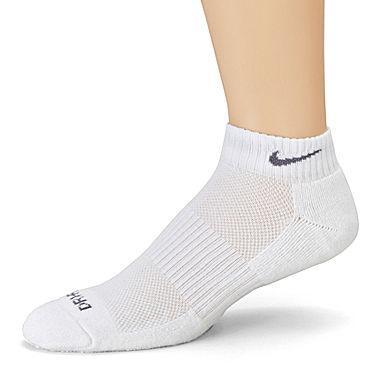
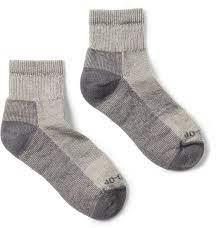
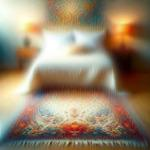
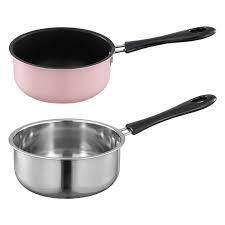
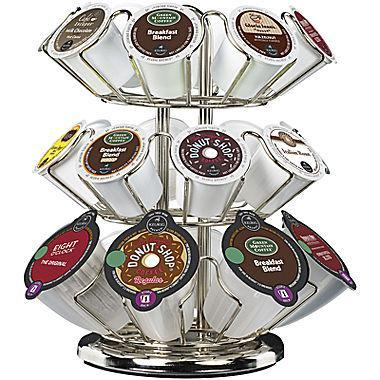

In [20]:
# Column containing image's path
image_path_column = ["image"]

image_cleanlab_df = data.merge(
    image_cleanlab_columns, left_on="image", right_on="image"
)
image_cleanlab_df.rename(columns={"category": "given_label"}, inplace=True)

image_label_issue = image_cleanlab_df.query(
    "is_label_issue", engine="python"
).sort_values("label_issue_score", ascending=False)
columns_to_display = image_path_column + label_issue_columns

display_image(image_label_issue.head(5)[columns_to_display])

**Outlier** images are auto-detected as those that look atypical from the rest of the dataset. Cleanlab Studio's AI understands the visual semantics of images and flags those that meaningfully stand out in this product catalog:

,image,rendered_image,given_label,outlier_score,is_outlier
844,images/844.jpg,,pants,0.382356,True
777,images/777.jpg,,kitchen & dining,0.349961,True
304,images/304.jpg,,kitchen & dining,0.331406,True
328,images/328.jpg,,bed & bath,0.316104,True
596,images/596.jpg,,accessories,0.308186,True

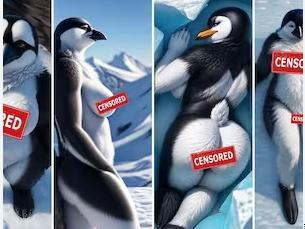
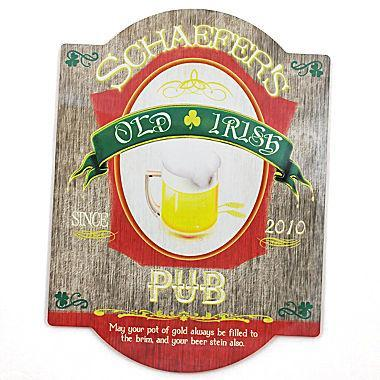
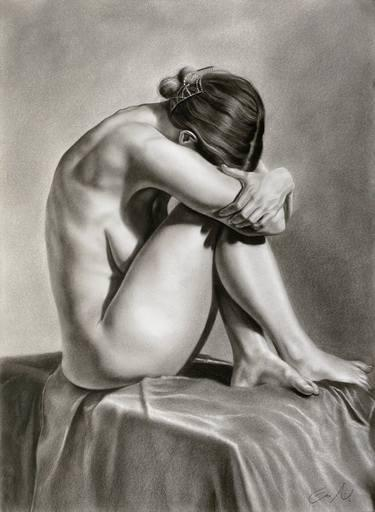
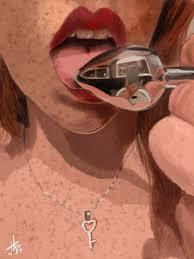
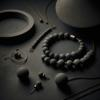

In [21]:
image_outlier_issue = image_cleanlab_df.query(
    "is_outlier", engine="python"
).sort_values("outlier_score", ascending=False)

outlier_columns = ["given_label", "outlier_score", "is_outlier"]
columns_to_display = image_path_column + outlier_columns

display_image(image_outlier_issue.head(5)[columns_to_display])

**Ambiguous** data points are not well-described by any class label in the dataset, or may be borderline cases between multiple class labels. Many ambiguous data points may indicate the class definitions were not very clear in the original category taxonomy defined for the product catalog (or data annotation/categorization instructions more generally). Consider closely reviewing the class labels for such ambiguous data. Unlike outliers which are very different from other data, ambiguous data may occur in clusters.

,image,rendered_image,given_label,ambiguous_score,is_ambiguous
414,images/414.jpg,,kitchen & dining,0.960864,True
861,images/861.jpg,,underwear & socks,0.960580,True
47,images/47.jpg,,shoes,0.959784,True
304,images/304.jpg,,kitchen & dining,0.958595,True
407,images/407.jpg,,kitchen & dining,0.953552,True

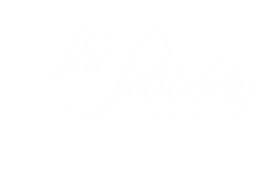
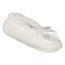
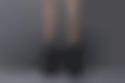
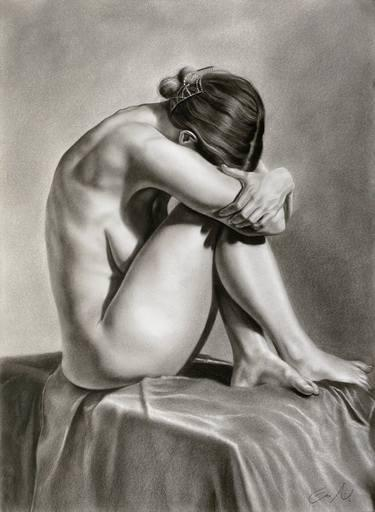
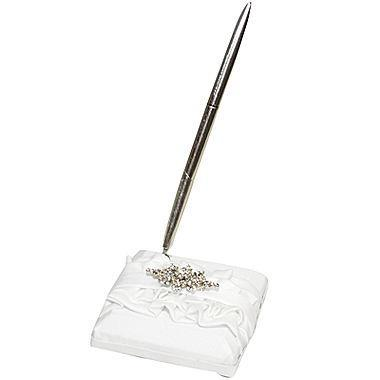

In [22]:
image_ambiguous_issue = image_cleanlab_df.query(
    "is_ambiguous", engine="python"
).sort_values("ambiguous_score", ascending=False)

ambiguous_columns = ["given_label", "ambiguous_score", "is_ambiguous"]
columns_to_display = image_path_column + ambiguous_columns

display_image(image_ambiguous_issue.head(5)[columns_to_display])

### Other data issues detected in image project

As with the text fields, Cleanlab can auto-detect various types of problem in image data. The following Cleanlab columns are specific to images (see [here](/studio/concepts/cleanlab_columns/#columns-specific-to-image-data) for details), and are useful for detecting low-quality or unsafe images (content moderation).

**Low-information** images lack content and exhibit low entropy in the values of their pixels. They do not help your customers reach a purchase decision and negatively affect the browsing experience.

Here are the low-information images Cleanlab detected in this product catalog:

,image,rendered_image,given_label,low_information_score,is_low_information
414,images/414.jpg,,kitchen & dining,0.785571,True
323,images/323.jpg,,accessories,0.707833,True
705,images/705.jpg,,bed & bath,0.707282,True

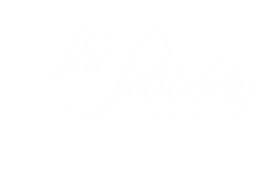
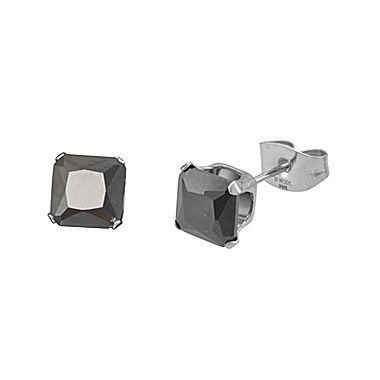
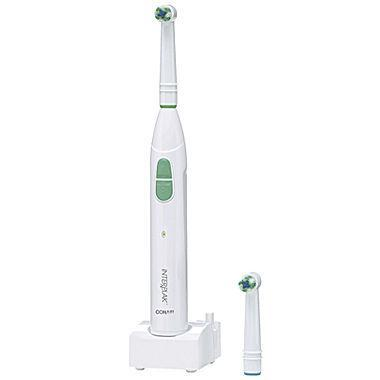

In [23]:
image_low_quality_issue = image_cleanlab_df.query(
    "is_low_information", engine="python"
).sort_values("low_information_score", ascending=False)

low_quality_columns = ["given_label", "low_information_score", "is_low_information"]
columns_to_display = image_path_column + low_quality_columns

display_image(image_low_quality_issue.head(5)[columns_to_display])

**Overly Dark** images appear dim/underexposed lacking clarity, and are obviously undesirable in a product catalog. 

Here are the dark images Cleanlab detected in this product catalog:

,image,rendered_image,given_label,dark_score,is_dark
1017,images/1017.jpg,,shoes,0.906149,True
1042,images/1042.jpg,,bed & bath,0.835294,True

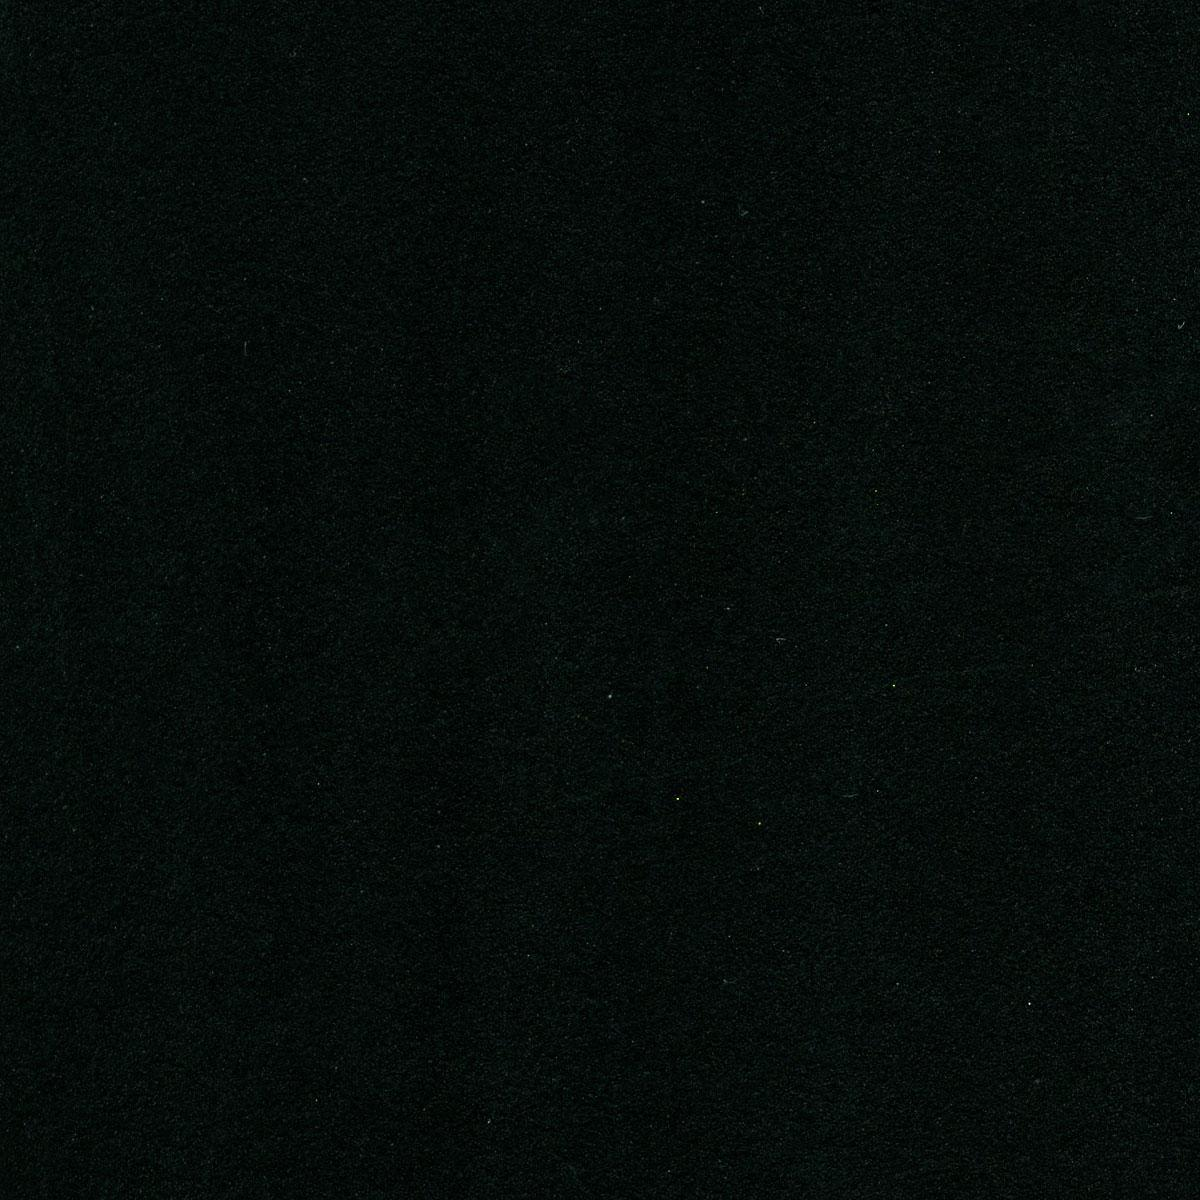
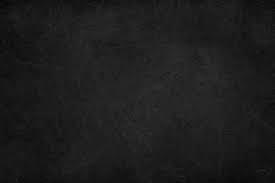

In [87]:
image_dark_issue = image_cleanlab_df.query("is_dark", engine="python").sort_values(
    "dark_score", ascending=False
)

dark_columns = ["given_label", "dark_score", "is_dark"]
columns_to_display = image_path_column + dark_columns

display_image(image_dark_issue.head(5)[columns_to_display])

**Overly Light** images appear excessively bright or overexposed, lacking adequate contrast and detail for a product catalog. Here are light images detected by Cleanlab:

,image,rendered_image,given_label,light_score,is_light
414,images/414.jpg,,kitchen & dining,0.996078,True

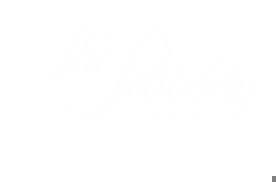

In [89]:
image_light_issue = image_cleanlab_df.query("is_light", engine="python").sort_values(
    "light_score", ascending=False
)

light_columns = ["given_label", "light_score", "is_light"]
columns_to_display = image_path_column + light_columns

display_image(image_light_issue.head(5)[columns_to_display])

**Aesthetic score:** Cleanlab Studio can compute an aesthetic score to quantify how visually appealing each image is (as rated by most people, although this is subjective). Use this score to automatically identify images which are non-realistic, artificial, or depict content that is not helpful for the customer to make a decision. For a product with multiple images, consider ordering them by aesthetic score in the display to boost customer engagement.

*Note: Higher aesthetic scores correspond to higher-quality images in the dataset (unlike many of Cleanlab's other issue scores).*

Here are the unaesthetic images with low aesthetic scores detected in this product catalog:

,image,rendered_image,given_label,aesthetic_score
352,images/352.jpg,,kitchen & dining,0.131365
95,images/95.jpg,,accessories,0.140328
102,images/102.jpg,,kitchen & dining,0.151972

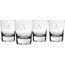
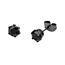
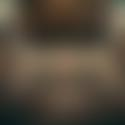

In [25]:
image_unaesthetic = image_cleanlab_df.sort_values("aesthetic_score", ascending=True)

aesthetic_columns = ["given_label", "aesthetic_score"]
columns_to_display = image_path_column + aesthetic_columns

display_image(image_unaesthetic.head(3)[columns_to_display])

**Odd Size and Odd Aspect Ratio** images have unusual area or width/height dimensions. On an ecommerce platform, such images may result in inconsistent & uneven display. If your website or application uses responsive design, odd-sized images might not adapt well to different screen sizes.

Here are the odd size or aspect ratio images Cleanlab detected in this product catalog:

In [ ]:
image_odd_size = image_cleanlab_df.query(
    "is_odd_aspect_ratio or is_odd_size"
).sort_values("odd_aspect_ratio_score", ascending=False)

odd_size_columns = [
    "given_label",
    "odd_aspect_ratio_score",
    "is_odd_aspect_ratio",
    "odd_size_score",
    "is_odd_size",
]
columns_to_display = image_path_column + odd_size_columns

display_image(image_odd_size.head(3)[columns_to_display])

,image,rendered_image,given_label,odd_aspect_ratio_score,is_odd_aspect_ratio,odd_size_score,is_odd_size
499,images/499.jpg,,kitchen & dining,0.821429,True,0.090175,False
486,images/486.jpg,,coats & jackets,0.750000,True,0.091837,False


In this dataset, there are odd aspect ratio images but no odd size images flagged above Cleanlab's `odd_size_score` threshold.

**Not Safe For Work (NSFW)** images are not suitable for viewing in a professional or public environment because they depict explicit/pornographic content or graphic violence/gore. These images must be removed from an ecommerce product catalog.

Here are the images that Cleanlab flagged as NSFW in this product catalog:

,image,rendered_image,given_label,NSFW_score,is_NSFW
844,images/844.jpg,,pants,0.611196,True

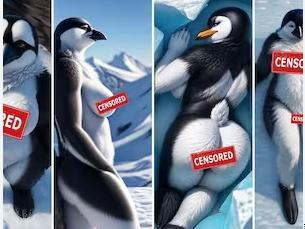

In [27]:
image_nsfw = image_cleanlab_df.query("is_NSFW").sort_values(
    "NSFW_score", ascending=False
)

nsfw_columns = ["given_label", "NSFW_score", "is_NSFW"]
columns_to_display = image_path_column + nsfw_columns

display_image(image_nsfw.head(1)[columns_to_display])

### Near duplicates

Cleanlab also automatically detects data points that are exact or near duplicates. Duplicate products confuse your customers and degrade your analytics and logistical efficiency.

Let's first review the near duplicate product descriptions detected from our text project:

In [28]:
n_near_duplicate_sets = len(
    set(
        description_cleanlab_df.loc[
            description_cleanlab_df["near_duplicate_cluster_id"].notna(),
            "near_duplicate_cluster_id",
        ]
    )
)
print(
    f"There are {n_near_duplicate_sets} sets of near duplicate samples from the 'description' text field."
)

There are 72 sets of near duplicate samples from the 'description' text field.


The nearly duplicated data points each have an associated `near_duplicate_cluster_id`.  Data points that share the same cluster IDs are near duplicates of each other. We can use this column to find the near duplicates of any data point. The `near_duplicate_score ` quantifies how semantically similar another data point is. This score = 1.0 for exactly duplicated data points, which have identical copies in the dataset.

In [29]:
near_duplicate_cluster_id = 10
description_near_duplicate_cluster = description_cleanlab_df.query(
    "near_duplicate_cluster_id == @near_duplicate_cluster_id", engine="python"
)

near_duplicate_columns = ["near_duplicate_score", "is_near_duplicate", "given_label"]
columns_to_display = tabular_columns + near_duplicate_columns

display(description_near_duplicate_cluster.head()[columns_to_display])

,title,description,sale_price,average_product_rating,brand,near_duplicate_score,is_near_duplicate,given_label
189,Clarks® Leisa Grove Leather Sandals,"Stay comfortable and looking great all day with these sandals that are crafted in luxurious leather. technology Cushion Soft technology offers softness you can feel from your first step, long-lasting comfort and fit with minimal cushion compression optimal breathability via open-cell technology OrthoLite® cushioned footbed absorbs impact and offers breathability, moisture management and is antimicrobial construction leather upper EVA sole details strappy open-toe design adjustable hook-and-loop closure fabric lining",60.42,4.8,Clarks,0.999996,True,shoes
951,Clarks® Leisa Grove Leather Sandals - Wide Width,"Stay comfortable and looking great all day with these sandals that are crafted in luxurious leather. technology Cushion Soft technology offers softness you can feel from your first step, long-lasting comfort and fit with minimal cushion compression optimal breathability via open-cell technology OrthoLite® cushioned footbed absorbs impact and offers breathability, moisture management and is antimicrobial construction leather upper EVA sole details strappy open-toe design adjustable hook-and-loop closure fabric lining",60.42,4.4,Clarks,0.999996,True,shoes


Let's also review the near duplicate product images detected in this dataset (from the image project):

In [30]:
n_near_duplicate_sets = len(
    set(
        image_cleanlab_df.loc[
            image_cleanlab_df["near_duplicate_cluster_id"].notna(),
            "near_duplicate_cluster_id",
        ]
    )
)
print(
    f"There are {n_near_duplicate_sets} sets of near duplicate samples identified from the images."
)

There are 50 sets of near duplicate samples identified from the images.


,image,rendered_image,title,description,sale_price,average_product_rating,brand,near_duplicate_score,is_near_duplicate,given_label
291,images/291.jpg,,adidas® Brand Cut Tee,"Our adidas brand cut t-shirt offers comfort, style and easy care. regular fit crewneck short sleeves cotton washable imported",21.53,3.1,ADIDAS,1.0,True,tops
872,images/872.jpg,,adidas® Brand Cut Tee,"Our adidas brand cut t-shirt offers comfort, style and easy care. regular fit crewneck short sleeves cotton washable imported",21.53,1.8,ADIDAS,1.0,True,tops

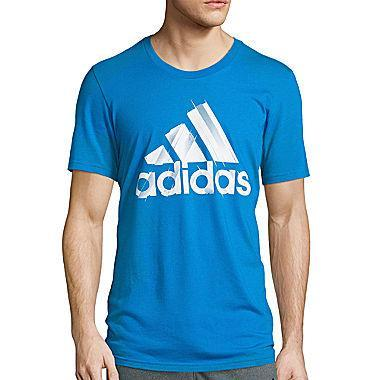
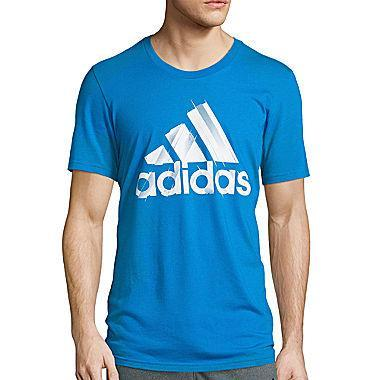

In [31]:
near_duplicate_cluster_id = (
    20  # play with this value to see other sets of near duplicates
)
image_near_duplicate_cluster = image_cleanlab_df.query(
    "near_duplicate_cluster_id == @near_duplicate_cluster_id", engine="python"
)

columns_to_display = image_path_column + tabular_columns + near_duplicate_columns
display_image(image_near_duplicate_cluster.head()[columns_to_display])

Cleanlab Studio automatically provides holistic quality assurance for your product catalog. The AI system closely evaluates diverse multi-modal information about each product, using its understanding of the content semantics to diagnose problems you never even considered. Cleanlab Studio automatically detects [many types of data issues](/studio/concepts/cleanlab_columns/) (not all demonstrated here).

**Next Steps:**  After auto-detecting all sorts of informational issues in a product catalog, you can alert the appropriate parties to fix these issues (e.g. the seller of a particular product in an e-commerce marketplace). It's this easy to use Data-Centric AI to improve your product catalog and delight your customers! Better quality data achieved with Cleanlab Studio will improve: customer engagement, product discoverability, and your sales.  

## Bonus: Detect erroneous numeric values (regression task) 

Previously we analyzed issues with respect to the specified product category, designating the ML task as *multi-class classification* within Cleanlab Studio. 
We can also use Cleanlab Studio for analyzing issues in numeric columns like *sale price*, *product ratings*, *size*, etc. by designating the ML task as **regression**.

Suppose we are interested in flagging suspicious (or potentially incorrect) values in the listed `sale_price` of certain products. We accomplish this in Cleanlab Studio by declaring this column as the *label* for a regression task.
Based on the same previous tabular dataset loaded into Cleanlab Studio, we can specify which columns to use as predictive features for inferring this label, and launch a "regression" project. Cleanlab will train its AI model to predict sales price based on these features, and then flag the values deemed least likely.

In [ ]:
# Name of the numeric column to detect issues in
regression_column = "sale_price"
# Name of the tabular columns to use as predictive features (including 'category' here)
tabular_columns_price = [
    "title",
    "description",
    "average_product_rating",
    "brand",
    "category",
]

tabular_price_project_id = studio.create_project(
    dataset_id=tabular_dataset_id,
    project_name="multimodal-tabular-price",
    modality="tabular",
    task_type="regression",
    model_type="regular",
    label_column=regression_column,
    feature_columns=tabular_columns_price,
)
print(
    f"Project successfully created and training has begun! project_id: {tabular_price_project_id}"
)

**You should only execute the above cell once!** Do not call `create_project` again. Come back after training is complete (you will receive an email).

In [ ]:
tabular_price_cleanset_id = studio.get_latest_cleanset_id(tabular_price_project_id)
project_status = studio.wait_until_cleanset_ready(tabular_price_cleanset_id)

tabular_price_cleanlab_columns = studio.download_cleanlab_columns(
    tabular_price_cleanset_id
)

# Combine original DataFrame with Cleanlab columns
tabular_price_cleanlab_df = data.merge(
    tabular_price_cleanlab_columns, left_index=True, right_index=True
)

# Set "given_label" column to the original label
tabular_price_cleanlab_df.rename(columns={"sale_price": "given_label"}, inplace=True)

In [32]:
tabular_price_label_issue = tabular_price_cleanlab_df.query(
    "is_label_issue", engine="python"
).sort_values("label_issue_score", ascending=False)
columns_to_display = tabular_columns_price + label_issue_columns

display(tabular_price_label_issue.head()[columns_to_display])

,title,description,average_product_rating,brand,category,given_label,suggested_label,label_issue_score,is_label_issue
254,Mixit™ Oval Bling Wedge Sandals,"With its shiny stone detail and extra height in the heel, our wedge sandal is the perfect blend of comfort, style and bling. manmade materials comfortable slip-on",5.0,MIXIT,shoes,1000.10,59.930344,1.0,True
142,Pillow covers free trial too,"Pillow with hearts that can be placed anywhere. Call us on 202 856 1167 for free trial."" spot clean imported",2.5,ß,bed & bath,456.78,55.065586,1.0,True
1086,Master Massage Olympic 32” Massage Table Set,"The Olympic LX massage table is all about revolutionary size and strength. At 32 inches wide with oversized ash wood legs and double thickness bed, this table supports up to 3,200 pounds",3.8,MASTER MASSAGE,bed & bath,640.56,62.977962,1.0,True
360,Nike® Team Training Gym Sack,"The Nike Team Training gym sack helps keep your gear organized with an interior divider and bonded zip pocket. The water-resistant fabric and polyurethane-coated bottom also help ensure your essentials stay dry. main compartment with drawcord closure water-resistant fabric zip pocket for secure, small-item storage perforated film provides breathability Swoosh graphic polyester spot clean imported",4.9,Nike,accessories,2011.76,51.723045,1.0,True
869,Onasis Backless Barstool,"Add sturdy and stylish seating to your counter or table with this backless barstool featuring splayed legs accented with a decorative wood trim. wood and rubberwood construction flush-joint joinery cushion filled with upholstery foam brushed bronze-tone nailhead accents 275-pound weight capacity Upholstery options: Faux leather: polyurethane; spot clean with a dry cloth; avoid direct heat and sunlight. Tweed: 75% polyester/25% acrylic; spot clean with a clean, damp cloth or have professionally cleaned. Assembly required; screwdriver needed. Imported. Counter-height barstool: 20Wx14Dx26""H Bar-height barstool: 21Wx15Dx32""H",5.0,Linon,kitchen & dining,464.60,81.529083,1.0,True


The original sales price of these flagged products seems suspiciously high. These are definitely worth a second look, good thing Cleanlab caught them! The `label_issue_score` reflects *how likely* Cleanlab's AI finds each product's listed sales price to be *incorrect*. 

You could repeat this bonus analysis with the **size**, **rating**, or other important numeric information about each product that is vital to get right.